In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy.random as random
import time

#### Define functions

In [116]:
def gen_data(num_samples, dim, sigma, scaling=1, seed=0):
    random.seed(seed)
    theta_gt = random.randint(0, 2, size=(dim,))
    x = random.randn(num_samples,dim) * scaling
    noise = random.randn(num_samples) * sigma
    y = x @ theta_gt + noise
    return x, y, theta_gt

def state_init(dim, sparsity=None, func="no_sparse_constraint"):
    if func == "no_sparse_constraint":
        init_theta = random.randint(0, 2, size=(dim,))
        return init_theta
    elif func == "sparse_constraint":
        assert sparsity is not None
        init_theta = np.zeros(dim)
        indices_of_ones = random.choice(dim, sparsity, replace=False)
        init_theta[indices_of_ones] = 1
        return init_theta
    else:
        raise NotImplementedError

def trans(x, curr_pred, theta, func="1_bit_random_flip", sparsity=None):
    new_theta = np.copy(theta)
    if func == "1_bit_random_flip":  # question 1
        ind = random.randint(0, len(theta))
        new_theta[ind] = 1 - theta[ind]
        diff = x[:, ind] * (1 - 2 * theta[ind])
    elif func == "2_bit_random_flip_for_sparsity":  # question 2 & 3, too slow
        indice_one = random.choice(np.where(theta==1)[0], 1)
        indice_zero = random.choice(np.where(theta==0)[0], 1)
        new_theta[indice_one] = 0
        new_theta[indice_zero] = 1
        diff = x[:, indice_zero] - x[:, indice_one]
    elif func == "2_bit_random_swap_for_sparsity":  # question 2 & 3, mentioned in the project description
        indices = random.choice(len(theta), 2, replace=False)
        if theta[indices[0]] == theta[indices[1]]:
            diff = 0
        else:
            new_theta[indices[0]], new_theta[indices[1]] = new_theta[indices[1]], new_theta[indices[0]]
            diff = x[:, indices[0]] * (1 - 2 * theta[indices[0]]) + x[:, indices[1]] * (1 - 2 * theta[indices[1]])
    elif func == "random_walk_for_sparsity":  # question 2 & 3
        assert sparsity is not None
        new_theta = np.zeros(len(theta))
        indices_of_ones = random.choice(len(theta), sparsity, replace=False)
        new_theta[indices_of_ones] = 1
        diff = x[:, indices_of_ones].sum(axis=1) - curr_pred
    else:
        raise NotImplementedError

    return new_theta, curr_pred + diff

def obj(y, pred, func="2-norm"):
    if func == "2-norm":
        return np.linalg.norm(y - pred)
    elif func == "1-norm":
        return np.linalg.norm(y - pred, ord=1)
    elif func == "test":  # to check if the obj is the bottleneck. The answer was yes.
        return 1
    else:
        raise NotImplementedError

def accept(beta, diff):
    if beta * diff <= 0:
        return 1
    else:
        return np.exp(-beta * diff)

# TOOD: better estimator
def opt_beta_estimator(x, y, obj, eps, dim, num_trials=1000):
    vals = []
    for _ in range(num_trials):
        theta = random.randint(0, 2, size=(dim,))
        vals.append(obj(x, y, theta))

def beta_generator(x, y, obj, eps, dim, num_iters=1000, func="constant"):
    if func == "constant":
        betas = np.ones((num_iters,))
    elif func == "optimal":
        betas = opt_beta_estimator(x, y, obj, eps, dim, num_trials=10000)
    elif func == "simulated_annealing":
        pass # TODO
    else:
        raise NotImplementedError
    return betas

def eval(theta_gt, thetas, coef, warmup_iters):
    if warmup_iters < 0:
        theta = thetas[-1]
    else:
        theta = np.mean(thetas[warmup_iters:], axis=0)
    return np.linalg.norm(theta_gt - theta) * coef

def run_MH(x, y, num_iters, betas, trans_func, obj_func, curr_theta, sparsity=None):
    thetas, vals = [], []
    curr_pred = x @ curr_theta
    curr_val = obj(y, curr_pred, obj_func)
    for i in range(num_iters):
        next_theta, next_pred= trans(x, curr_pred, curr_theta, trans_func, sparsity=sparsity)
        next_val = obj(y, next_pred, obj_func)
        # print(next_val - curr_val)
        acceptance = accept(betas[i], next_val - curr_val)
        if random.random() <= acceptance:
            curr_theta = next_theta
            curr_pred = next_pred
            curr_val = next_val
        thetas.append(curr_theta)
        vals.append(curr_val)
    return thetas, vals

### Global variables

In [106]:
num_samples =[10, 50, 100, 500, 1000, 2000, 3000] # number of samples
dim=2000 # [2000, 5000]
sigma = 1 # noise
num_iters = 100 * dim
warmup_iters = 20 * dim # assume convergence after warmup
seeds = range(1)
eps = 0.8  # for beta estimation

### Question 1

In [69]:
obj_func = "2-norm"
trans_func = "1_bit_random_flip"
init_func = "no_sparse_constraint"
beta_func = "constant"
coef = 2/dim

all_errors, all_vals= [], []

for m in num_samples:
    error, vals = 0, np.zeros((num_iters,))
    for s in seeds:
        x, y, theta_gt = gen_data(m, dim, sigma, seed=s)
        betas = beta_generator(x, y, obj, eps, dim, num_iters, beta_func)
        init_theta = state_init(dim, init_func)
        theta_seq, val_seq = run_MH(x, y, num_iters, betas, trans_func, obj_func, init_theta)

        error += eval(theta_gt, theta_seq, coef, warmup_iters=-1)/len(seeds) # estimate mean squared error, averaged over theta and X
        vals += np.array(val_seq)/len(seeds)

    all_errors.append(error)
    all_vals.append(vals)


Text(0, 0.5, 'mean squared error')

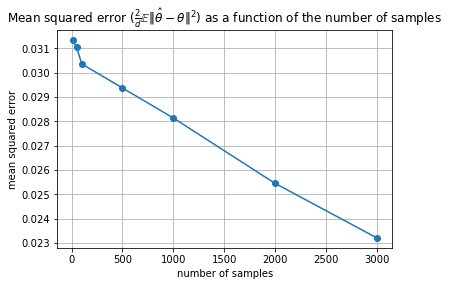

In [70]:
# plot the means squraed error as a function of the number of samples
plt.plot(num_samples, all_errors, marker='o')
plt.grid()
plt.title(r"Mean squared error ($\frac{2}{d}\mathbb{E} \Vert \hat{\theta}-\theta \Vert ^2$) as a function of the number of samples")  # remember to change the coef
plt.xlabel("number of samples")
plt.ylabel("mean squared error")

Text(0, 0.5, 'Objective')

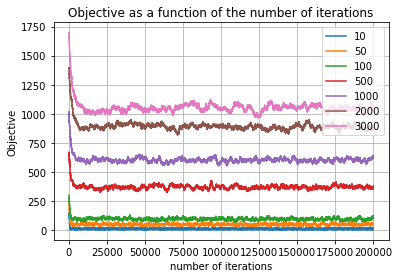

In [71]:
# plot the objective as a function of the number of iterations
for i, vals in enumerate(all_vals):
    plt.plot(range(len(vals)), vals)
plt.grid()
plt.legend(num_samples)
plt.title(r"Objective as a function of the number of iterations")  # remember to change the coef
plt.xlabel("number of iterations")
plt.ylabel("Objective")

### Question 2
we start with the transition function that is mentioned in the project description

In [107]:
# compared to question 1, we change transition function, initialization function and the coefficient
obj_func = "2-norm"
trans_func = "2_bit_random_swap_for_sparsity"
init_func = "sparse_constraint"
beta_func = "constant"
sparsity = int(dim/100) # only used for question 2 & 3
coef = 1/(2 * sparsity)

all_errors, all_vals= [], []

for m in num_samples:
    error, vals = 0, np.zeros((num_iters,))

    for s in seeds:
        x, y, theta_gt = gen_data(m, dim, sigma, seed=s)
        betas = beta_generator(x, y, obj, eps, dim, num_iters, beta_func)
        init_theta = state_init(dim, sparsity, init_func)

        theta_seq, val_seq = run_MH(x, y, num_iters, betas, trans_func, obj_func, init_theta)

        error += eval(theta_gt, theta_seq, coef, warmup_iters)/len(seeds) # estimate mean squared error, averaged over theta and X
        vals += np.array(val_seq)/len(seeds)

    all_errors.append(error)
    all_vals.append(vals)

Text(0, 0.5, 'mean squared error')

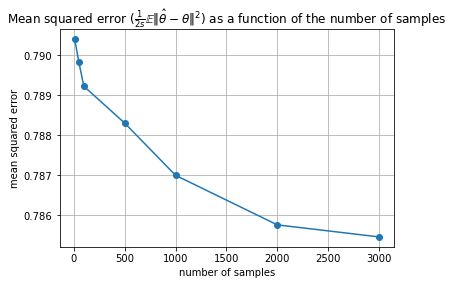

In [108]:
# plot the means squraed error as a function of the number of samples
plt.plot(num_samples, all_errors, marker='o')
plt.grid()
plt.title(r"Mean squared error ($\frac{1}{2s}\mathbb{E} \Vert \hat{\theta}-\theta \Vert ^2$) as a function of the number of samples")  # remember to change the coef
plt.xlabel("number of samples")
plt.ylabel("mean squared error")

Text(0, 0.5, 'Objective')

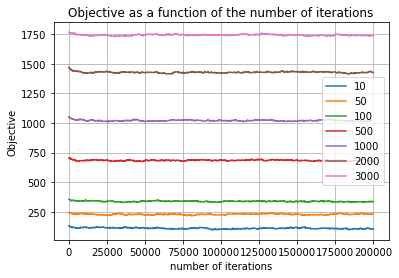

In [109]:
# plot the objective as a function of the number of iterations
for i, vals in enumerate(all_vals):
    plt.plot(range(len(vals)), vals)
plt.grid()
plt.legend(num_samples)
plt.title(r"Objective as a function of the number of iterations")  # remember to change the coef
plt.xlabel("number of iterations")
plt.ylabel("Objective")

#### Not converged, is it because of sparsity?
It might because the transition prob for self-loop is too high in the above case, especially when the theta is sparse. Below we show that reducing sparsity improves the convergence.

In [110]:
# compared to question 1, we change transition function, initialization function and the coefficient
obj_func = "2-norm"
trans_func = "2_bit_random_swap_for_sparsity"
init_func = "sparse_constraint"
beta_func = "constant"
sparsity = int(dim/5) # only used for question 2 & 3
coef = 1/(2 * sparsity)

all_errors, all_vals= [], []

for m in num_samples:
    error, vals = 0, np.zeros((num_iters,))

    for s in seeds:
        x, y, theta_gt = gen_data(m, dim, sigma, seed=s)
        betas = beta_generator(x, y, obj, eps, dim, num_iters, beta_func)
        init_theta = state_init(dim, sparsity, init_func)

        theta_seq, val_seq = run_MH(x, y, num_iters, betas, trans_func, obj_func, init_theta)

        error += eval(theta_gt, theta_seq, coef, warmup_iters)/len(seeds) # estimate mean squared error, averaged over theta and X
        vals += np.array(val_seq)/len(seeds)

    all_errors.append(error)
    all_vals.append(vals)

Text(0, 0.5, 'mean squared error')

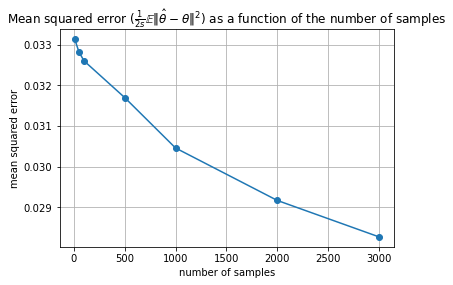

In [111]:
# plot the means squraed error as a function of the number of samples
plt.plot(num_samples, all_errors, marker='o')
plt.grid()
plt.title(r"Mean squared error ($\frac{1}{2s}\mathbb{E} \Vert \hat{\theta}-\theta \Vert ^2$) as a function of the number of samples")  # remember to change the coef
plt.xlabel("number of samples")
plt.ylabel("mean squared error")

Text(0, 0.5, 'Objective')

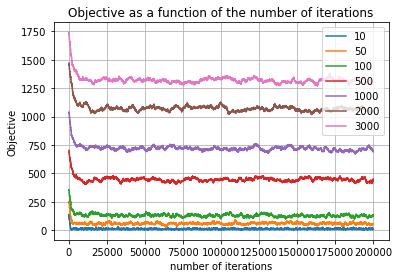

In [112]:
# plot the objective as a function of the number of iterations
for i, vals in enumerate(all_vals):
    plt.plot(range(len(vals)), vals)
plt.grid()
plt.legend(num_samples)
plt.title(r"Objective as a function of the number of iterations")  # remember to change the coef
plt.xlabel("number of iterations")
plt.ylabel("Objective")

#### How about without self-loop?
This one removes the self-loop.

In [ ]:
# compared to question 1, we change transition function, initialization function and the coefficient
obj_func = "2-norm"
trans_func = "2_bit_random_flip_for_sparsity"
init_func = "sparse_constraint"
beta_func = "constant"
sparsity = int(dim/100) # only used for question 2 & 3
coef = 1/(2 * sparsity)

all_errors, all_vals= [], []

for m in num_samples:
    error, vals = 0, np.zeros((num_iters,))

    for s in seeds:
        x, y, theta_gt = gen_data(m, dim, sigma, seed=s)
        betas = beta_generator(x, y, obj, eps, dim, num_iters, beta_func)
        init_theta = state_init(dim, sparsity, init_func)

        theta_seq, val_seq = run_MH(x, y, num_iters, betas, trans_func, obj_func, init_theta)

        error += eval(theta_gt, theta_seq, coef, warmup_iters)/len(seeds) # estimate mean squared error, averaged over theta and X
        vals += np.array(val_seq)/len(seeds)

    all_errors.append(error)
    all_vals.append(vals)

In [ ]:
# plot the means squraed error as a function of the number of samples
plt.plot(num_samples, all_errors, marker='o')
plt.grid()
plt.title(r"Mean squared error ($\frac{1}{2s}\mathbb{E} \Vert \hat{\theta}-\theta \Vert ^2$) as a function of the number of samples")  # remember to change the coef
plt.xlabel("number of samples")
plt.ylabel("mean squared error")

In [ ]:
# plot the objective as a function of the number of iterations
for i, vals in enumerate(all_vals):
    plt.plot(range(len(vals)), vals)
plt.grid()
plt.legend(num_samples)
plt.title(r"Objective as a function of the number of iterations")  # remember to change the coef
plt.xlabel("number of iterations")
plt.ylabel("Objective")

#### How about random walk in a clique?
There is self-loop (since it's a random walk), but the transition prob is not too high.

In [115]:
# compared to question 1, we change transition function, initialization function and the coefficient
obj_func = "2-norm"
trans_func = "random_walk_for_sparsity"
init_func = "sparse_constraint"
beta_func = "constant"
sparsity = int(dim/100) # only used for question 2 & 3
coef = 1/(2 * sparsity)

all_errors, all_vals= [], []

for m in num_samples:
    error, vals = 0, np.zeros((num_iters,))

    for s in seeds:
        x, y, theta_gt = gen_data(m, dim, sigma, seed=s)
        betas = beta_generator(x, y, obj, eps, dim, num_iters, beta_func)
        init_theta = state_init(dim, sparsity, init_func)

        theta_seq, val_seq = run_MH(x, y, num_iters, betas, trans_func, obj_func, init_theta, sparsity=sparsity)

        error += eval(theta_gt, theta_seq, coef, warmup_iters)/len(seeds) # estimate mean squared error, averaged over theta and X
        vals += np.array(val_seq)/len(seeds)

    all_errors.append(error)
    all_vals.append(vals)

Text(0, 0.5, 'mean squared error')

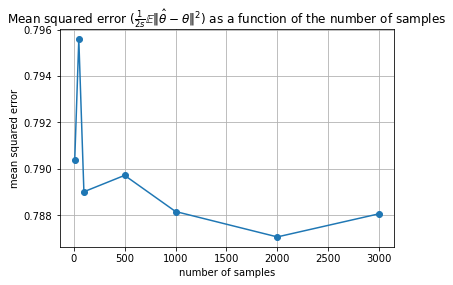

In [117]:
# plot the means squraed error as a function of the number of samples
plt.plot(num_samples, all_errors, marker='o')
plt.grid()
plt.title(r"Mean squared error ($\frac{1}{2s}\mathbb{E} \Vert \hat{\theta}-\theta \Vert ^2$) as a function of the number of samples")  # remember to change the coef
plt.xlabel("number of samples")
plt.ylabel("mean squared error")

Text(0, 0.5, 'Objective')

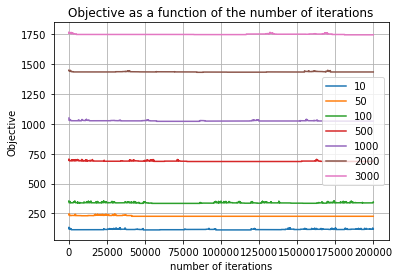

In [118]:
# plot the objective as a function of the number of iterations
for i, vals in enumerate(all_vals):
    plt.plot(range(len(vals)), vals)
plt.grid()
plt.legend(num_samples)
plt.title(r"Objective as a function of the number of iterations")  # remember to change the coef
plt.xlabel("number of iterations")
plt.ylabel("Objective")

### Question 3

In [ ]:
# compared to question 2, we change objective function (TODO)
obj_func = "2-norm"
trans_func = "2_bit_random_flip_for_sparsity"
init_func = "sparse_constraint"
beta_func = "constant"
sparsity = int(dim/100) # only used for question 2 & 3
coef = 1/(2 * sparsity)

all_errors, all_vals= [], []

for m in num_samples:
    error, vals = 0, np.zeros((num_iters,))

    for s in seeds:
        x, y, theta_gt = gen_data(m, dim, sigma, seed=s)
        betas = beta_generator(x, y, obj, eps, dim, num_iters, beta_func)
        init_theta = state_init(dim, sparsity, init_func)

        theta_seq, val_seq = run_MH(x, y, num_iters, betas, trans_func, obj_func, init_theta)

        error += eval(theta_gt, theta_seq, coef, warmup_iters)/len(seeds) # estimate mean squared error, averaged over theta and X
        vals += np.array(val_seq)/len(seeds)

    all_errors.append(error)
    all_vals.append(vals)

In [ ]:
# plot the means squraed error as a function of the number of samples
plt.plot(num_samples, all_errors, marker='o')
plt.grid()
plt.title(r"Mean squared error ($\frac{1}{2s}\mathbb{E} \Vert \hat{\theta}-\theta \Vert ^2$) as a function of the number of samples")  # remember to change the coef
plt.xlabel("number of samples")
plt.ylabel("mean squared error")

In [ ]:
# plot the objective as a function of the number of iterations
for i, vals in enumerate(all_vals):
    plt.plot(range(len(vals)), vals)
plt.grid()
plt.legend(num_samples)
plt.title(r"Objective as a function of the number of iterations")  # remember to change the coef
plt.xlabel("number of iterations")
plt.ylabel("Objective")